In [1]:
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv('/home/DS-DH/notebooks/digitalHouse/properatti.csv')

In [396]:
matriz = pd.read_csv('/home/DS-DH/notebooks/digitalHouse/matriz.csv',sep='|')

In [397]:
matriz = matriz.loc[matriz.localidad.str.contains('capital')]

In [398]:
data_= matriz

In [262]:
data_ = data_[data_.superficie_total<4000]

In [395]:
def outliers(p_data):


    data_modificada = p_data

    # GENERO CULUMNA DE MEDIAS AGRUPANDO POR PCIA, BARRIO, TIPO DE PROPIEDAD
    data_modificada ['media_supTotal'] = data_modificada.groupby(['localidad','barrio','propiedad'])['superficie_total'].transform('mean')
    data_modificada ['media_supCubierta'] = data_modificada.groupby(['localidad','barrio','propiedad'])['superficie_cubierta_m2'].transform('mean')
    data_modificada ['media_PrecioM2'] = data_modificada.groupby(['localidad','barrio','propiedad'])['precio_m2'].transform('mean')
    data_modificada ['media_PrecioAproxUSD'] = data_modificada.groupby(['localidad','barrio','propiedad'])['precio_aprox_usd'].transform('mean')


    #GENERO COLUMNA DE STD AGRUPANDO POR PCIA, BARRIO, TIPO DE PROPIEDAD
    data_modificada ['std_supTotal'] = data_modificada.groupby(['localidad','barrio','propiedad'])['superficie_total'].transform('std')
    data_modificada ['std_supCubierta'] = data_modificada.groupby(['localidad','barrio','propiedad'])['superficie_cubierta_m2'].transform('std')
    data_modificada ['std_PrecioM2'] = data_modificada.groupby(['localidad','barrio','propiedad'])['precio_m2'].transform('std')
    data_modificada ['std_PrecioAproxUSD'] = data_modificada.groupby(['localidad','barrio','propiedad'])['precio_aprox_usd'].transform('std')


    #GENERO COLUMNA CON LA FORMULA DE CHEUVENET PARA EL CALCULO DE OUTLIERS
    data_modificada ['supTotal_criterio_cheuvenet'] = (abs(data_modificada.superficie_total-data_modificada.media_supTotal))/(data_modificada.std_supTotal)
    data_modificada ['supCubierta_criterio_cheuvenet'] = (abs(data_modificada.superficie_cubierta_m2-data_modificada.media_supCubierta))/(data_modificada.std_supCubierta)
    data_modificada ['priceM2_criterio_cheuvenet'] = (abs(data_modificada.precio_m2-data_modificada.media_PrecioM2))/(data_modificada.std_PrecioM2)
    data_modificada ['priceAprox_criterio_cheuvenet'] = (abs(data_modificada.precio_aprox_usd-data_modificada.media_PrecioAproxUSD))/(data_modificada.std_PrecioAproxUSD)

    
    
    #  % OUTLIERS SUPERFICIES TOTALES
    data_modificada.loc[data_modificada.supTotal_criterio_cheuvenet>0.5].shape[0]/data_modificada.shape[0]    
    data_modificada.superficie_total.loc[data_modificada.supTotal_criterio_cheuvenet>0.5] = np.nan
    
    
    #  % OUTLIERS SUPERFICIES CUBIERTAS
    data_modificada.loc[data_modificada.supCubierta_criterio_cheuvenet>3].shape[0]/data_modificada.shape[0] 
    data_modificada.superficie_cubierta_m2.loc[data_modificada.supCubierta_criterio_cheuvenet>3] = np.nan
    
    
    #  % OUTLIERS DE PRECIOS APROX USD
    data_modificada.precio_aprox_usd.loc[data_modificada.priceAprox_criterio_cheuvenet>3].shape[0]/data_modificada.shape[0]   
    data_modificada.precio_aprox_usd.loc[data_modificada.priceAprox_criterio_cheuvenet>3] = np.nan
    
    #  % OUTLIERS DE PRECIOS POR M2
    data_modificada.loc[data_modificada.priceM2_criterio_cheuvenet>3].shape[0]/data_modificada.shape[0]
    data_modificada.precio_m2.loc[data_modificada.priceM2_criterio_cheuvenet>3] = np.nan
    
    
    
    return data_modificada 

In [399]:
data_ = outliers(matriz)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [400]:
#GENERO AMBIENTES DE MATRIZ
#data_['ambientes']=data_.merge(matriz,how='left', left_index=True, right_index=True)['ambientes']

#GENERO DUMMYS DE AMBIENTES
data_['1_AMBIENTE'] = (data_.ambientes>=1)&(data_.ambientes<2)
data_['2_AMBIENTE'] = (data_.ambientes>=2)&(data_.ambientes<3)
data_['3_AMBIENTE'] = (data_.ambientes>=3)&(data_.ambientes<4)
data_['4_AMBIENTE'] = (data_.ambientes>=4)&(data_.ambientes<5)
data_['5_AMBIENTE'] = (data_.ambientes>=5)&(data_.ambientes<6)
data_['6_AMBIENTE'] = (data_.ambientes>=6)&(data_.ambientes<7)
data_['7_AMBIENTE'] = (data_.ambientes>=7)&(data_.ambientes<8)


data_[['1_AMBIENTE','2_AMBIENTE','3_AMBIENTE','4_AMBIENTE', '5_AMBIENTE','6_AMBIENTE','7_AMBIENTE']] = data_[['1_AMBIENTE','2_AMBIENTE','3_AMBIENTE','4_AMBIENTE', '5_AMBIENTE','6_AMBIENTE','7_AMBIENTE']].applymap(lambda x : 1 if (x) else 0)


#GENERO DUMMYS TIPO DE PROPIEDAD 
data_['CASA'] = data_.propiedad.str.contains('house')
data_['PH'] =  data_.propiedad.str.contains('PH')
data_['DTO'] = data_.propiedad.str.contains('apartment')
data_[['CASA','PH','DTO']] = data_[['CASA','PH','DTO']].applymap(lambda x : 1 if x else 0)


#ELIMINO REGISTROS NULOS DE VARIABLES A UTILIZAR EN EL MODELO
data_=data_[data_.precio_m2.notnull()]
data_=data_[data_.superficie_total.notnull()]
data_=data_[data_.ambientes.notnull()]


#GENERO DUMMYS DE BARRIOS

#QUITO NULOS DE LA COLUMNA STATE_NAME
data_ = data_[data_.barrio.notnull()]


#CREO LISTA DE BARRIOS 
barrios = data_[data_.localidad.str.contains('capital')].barrio.unique()


#GENERO DUMMYS
for barrio in barrios:
    indices_barrios = (data_.index[data_.barrio.str.contains(barrio)])
    barrio = barrio.lower().replace(' ','_')
    df = data_
    df.barrio = df.barrio.apply(lambda x : x.lower().replace(' ','_'))
    df[barrio] = df.barrio.str.contains(barrio)



numero_barrios = len(data_.barrio[data_.localidad.str.contains('capital')].unique())
indices_dummys_barrios = data_.shape[1]-numero_barrios

#CREO EL DATAFRAME CON LAS DUMMYS DE BARRIOS
dummys_barrios = data_.iloc[:,indices_dummys_barrios:]


dummys_barrios = dummys_barrios.applymap(lambda x : 1 if (x) else 0)


#GENERO DUMMYS DE BARRIOS EN EL DATAFRAME
data_.iloc[:,indices_dummys_barrios:] = dummys_barrios


In [401]:
data_ = data_[data_.localidad.str.contains('capital')]

In [270]:
xs

,superficie_total,CASA,PH,DTO,mataderos,belgrano,palermo_soho,palermo,flores,boedo,...,villa_luro,palermo_chico,villa_general_mitre,villa_santa_rita,parque_centenario,versalles,villa_ortuzar,villa_soldati,villa_real,villa_riachuelo
0,55.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55.0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,45.0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,65.0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,50.0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14,42.0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16,140.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,104.0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21,118.0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29,43.0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [419]:
#SKLEARN

#GENERO VARIABLES INDEPENDIENTES
x_feactures = data_.iloc[:,38:][(data_.superficie_total<50)&(data_.precio_m2<35000)]
df1 = data_['superficie_total'][(data_.superficie_total<50)&(data_.precio_m2<35000)]
xs = pd.concat([df1,x_feactures],axis=1)


In [418]:

#GENERO VARIABLE DEPENDIENTE
y = data_.precio_m2[(data_.superficie_total<50)&(data_.precio_m2<35000)]

In [420]:
#TRANSFORMO VARIABLES INDEPENDIENTES EN FORMATO MATRIZ
xs = xs.as_matrix()


#TRANSFORMO VARIABLE DEPENDIENTE EN FORMATO MATRIZ
y = y.as_matrix()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [421]:
#IMPORTAR LIBRERIAS DE SKLEARN
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [422]:
#PARTICIONAR DATOS DE ENTRENAMIENTO Y TESTING
x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.4)

In [423]:
modelo = linear_model.LinearRegression()

In [424]:
#FIT 
modelo.fit(x_train,y_train)
#PREDECIR DATOS "Y" DE "X" TEST 
y_predict = modelo.predict(x_test)
#PENDIENTES
pendientes = modelo.coef_
#ORDENADA 
ordenada = modelo.intercept_
#R2
print(modelo.score(x_train,y_train))

0.5116295530456167


In [425]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(modelo, x_train, y_train, cv= 4)
print(scores.mean())

0.5075680227924261


In [384]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.astype(int), y_predict.astype(int))

0.0019164430816404753

In [350]:
    df = pd.DataFrame({'1':pd.Series(y_test),'2':pd.Series(y_predict)})

In [279]:
x_test[:,0]

array([ 50.,  24.,  62., ..., 116.,  60., 116.])

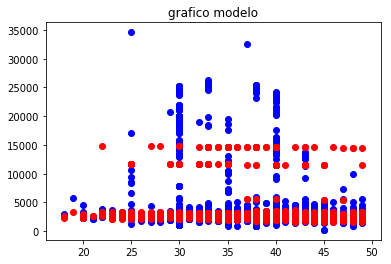

In [426]:
import matplotlib.pyplot as plt

#GENERO EJE X -> SUPERFICIE TOTAL
x1 = x_test[:,0]

#GENERO EJE Y -> PRECIO M2 DE TEST
x2 = y_test

# EJE Y -> PRECIO M2 PREDICHO
x3 = y_predict


#PLOT
plt.scatter(x1,x2,label='test modelo', color='blue')
plt.scatter(x1,x3,label='prediccion modelo', color='red')
plt.title('grafico modelo')
plt.show()